# fMRI Data Loading and Normalization in Python 
**V.0.2 - Beta, [Contributions](#contributions)**   

### Goal of this script
 1. load the fMRI data into python
 2. create an average brain mask from multiple runs
 3. trim TRs from the beginning of each run (and apply this trimming to the confounds as well)
 4. apply a high-pass filter and z-score the data
 5. concatonate runs to make one time series
 6. plot a timeseries for a voxel

## Table of Contents
[1. Import necessary packages](#import)  

[2. Load in timing files](#load_timing)  
>[2.1 Timing file description](#load_timing_describe)  
>[2.2 Plot stimulus presentation](#plot)  

[3. Load fMRI](#load_fmri)  
>[3.1 Plot voxel time series](#plot_voxel)  

[4. Normalization](#zscore)  
>[4.1 Check the z scoring](#zscore_check)  

## Import necessary packages

In [1]:
import warnings
import sys 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
import numpy as np
import nibabel as nib
from nilearn.input_data import NiftiMasker,  MultiNiftiMasker
from nilearn.masking import intersect_masks
from nilearn import image
from nilearn.plotting import plot_roi
from nilearn.plotting import plot_anat
from scipy import stats
from sklearn import preprocessing
import matplotlib.pyplot as plt 
#import seaborn as sns 
import scipy.io

%matplotlib inline 
%autosave 5
#sns.set(style = 'white', context='poster', rc={"lines.linewidth": 2.5})

Autosaving every 5 seconds


## Load settings

In [2]:
sub = 'sub-104'

# load some helper functions
#from svd_utils import load_svd_stim_labels, load_svd_mask, load_svd_epi_data
from svd_utils import load_svd_epi_data

# load some constants
from svd_utils import svd_data_dir, svd_bids_dir, svd_all_ROIs, svd_label_dict, svd_n_runs, svd_TR

n_trunc=2 # Number of volumes to trim/truncate

bold_dir=svd_bids_dir + 'derivatives/fmriprep/%s/ses-00/func/' % sub
anat_dir=svd_bids_dir + 'derivatives/fmriprep/%s/anat/' % sub
my_fold= svd_bids_dir + 'derivatives/firstlevel/%s/ses-00/' % sub

print('bids dir = %s' % (svd_bids_dir))
print('')
print('subject dir = %s' % (bold_dir))
print('')
print('output dir = %s' % (my_fold))
print('')
#print('ROIs = %s' % (svd_all_ROIs))
#print('Labels = %s' % (svd_label_dict))
print('number of runs = %d' % (svd_n_runs))
print('TR = %s seconds' % (svd_TR))
print('trim %d volumes from each run' % (n_trunc))


bids dir = /jukebox/norman/emcdevitt/studies/SVD/data/bids/Norman/McDevitt/7137_viodiff/

subject dir = /jukebox/norman/emcdevitt/studies/SVD/data/bids/Norman/McDevitt/7137_viodiff/derivatives/fmriprep/sub-104/ses-00/func/

output dir = /jukebox/norman/emcdevitt/studies/SVD/data/bids/Norman/McDevitt/7137_viodiff/derivatives/firstlevel/sub-104/ses-00/

number of runs = 2
TR = 1.5 seconds
trim 2 volumes from each run


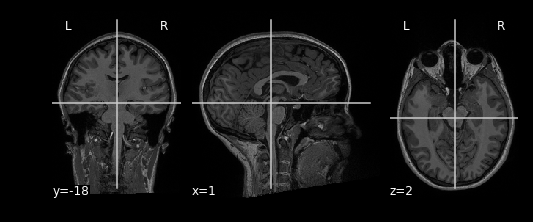

In [5]:
epi_mask_data_all=[]

t1_file = anat_dir + sub + '_desc-preproc_T1w.nii.gz'
t1_img = image.load_img(t1_file) 
plot_anat(t1_img)

## Load fMRI data <a id="load_fmri"></a>

#### Get voxels from an ROI

We will extract BOLD data, only for voxels in a mask, by executing the following sequence of steps: 
1. load whole brain fMRI data (for a given subject and a given run)
2. load the mask of FFA 
3. use `NiftiMasker` to sub-select FFA voxels from the whole brain data
    - `NiftiMasker` is a function from nilearn. Here's <a href="https://nilearn.github.io/auto_examples/04_manipulating_images/plot_mask_computation.html">an example</a> about how to use it, and here's the official <a href="https://nilearn.github.io/modules/generated/nilearn.input_data.NiftiMasker.html">documentation</a>. 

## Select confounds and trim volumes from confounds file

In [ ]:
import pandas as pd
# Use only the last 6 columns
confounds=[]
mc_all=[]
for r in range(1,svd_n_runs+1):
    fname='_ses-00_task-localizer_run-0%i_desc-confounds_regressors.tsv' % (r)
    confounds = pd.read_csv(bold_dir + sub + fname,  sep='\t', header=(0))
    confounds_selected=confounds[['trans_x','trans_y','trans_z','rot_x','rot_y','rot_z']][n_trunc:]
    confounds_selected=pd.DataFrame(confounds_selected)
    confounds_selected.to_csv(my_fold + sub + '_ses-00_task-localizer_run-0%i_confounds_selected.txt' % r, index=False, sep='\t', mode='w')
    
    print(confounds_selected)

## Create an average mask

Make an average mask by intersecting the mask for each run.

In [6]:
mask_imgs=[]
for run in range(1,svd_n_runs+1):
    mask_name = bold_dir + sub + '_ses-00_task-localizer_run-0%i_space-T1w_desc-brain_mask.nii.gz' % run
    # Issue with different runs having different voxels
    mask_imgs.append(mask_name)
avg_mask=intersect_masks(mask_imgs, threshold=0.5, connected=True)

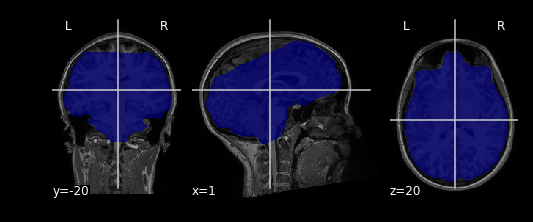

In [7]:
#plot_roi(avg_mask) #this plots with MNI template as background
plot_roi(avg_mask, bg_img=t1_img)

## Drop first few TRs

`n_trunc` sets the number of TRs to drop.

In [ ]:
epi_trunc=[]
for run in range(1,svd_n_runs+1):
    epi_file=bold_dir + sub + '_ses-00_task-localizer_run-0%i_space-T1w_desc-preproc_bold.nii.gz' % run
    epi_data=nib.load(epi_file)
    epi=epi_data.get_data()
    
    #hdr=epi_data.get_data.hdr()
    epi_trunc =np.zeros((epi_data.shape[0], epi_data.shape[1], epi_data.shape[2], epi_data.shape[3]-n_trunc))
    epi_trunc[:, :, :, :] = epi[:,:,:,n_trunc:]
    #epi_truncated
    print(epi_data.shape, '  ', epi_trunc.shape)
    dimsize=epi_data.header.get_zooms()
    print(dimsize)
    
    affine_mat = epi_data.affine  # What is the orientation of the data
    print(affine_mat)
    
    # Save the volume
    output_name = (my_fold + '%s_ses-00_task-localizer_run-0%i_space-T1w_desc-preproc_bold_truncTrs.nii.gz' % (sub, run))
    bold_nii = nib.Nifti1Image(epi_trunc, affine_mat)
    hdr = bold_nii.header  # get a handle for the .nii file's header
    hdr.set_zooms((dimsize[0], dimsize[1], dimsize[2], epi_trunc.shape[3]))
    nib.save(bold_nii, output_name)

## Apply mask to truncated dataset

In [8]:
from svd_utils import load_data
epi_mask_data_all=[]

# 1. Load the fMRI data 
for run in range(1,svd_n_runs+1):

    epi_masker= NiftiMasker(mask_img=avg_mask,  high_pass=1/128,
        standardize=True,  # Are you going to zscore the data across time?
        t_r=svd_TR, 
        memory='nilearn_cache',  # Caches the mask in the directory given as a string here so that it is easier to load and retrieve
        memory_level=1,  # How much memory will you cache?
        verbose=0
    )

    epi_file=my_fold + '%s_ses-00_task-localizer_run-0%i_space-T1w_desc-preproc_bold_truncTrs.nii.gz' % (sub, run)
    # confound_file= bold_dir + '%s_confounds_selected_r0%i.txt' % (sub, run)
    # epi_mask_data = epi_masker.fit_transform(epi_file, confounds=confound_file)
    epi_mask_data = epi_masker.fit_transform(epi_file)
    if run==1:
        epi_mask_data_all=epi_mask_data
    else:
        epi_mask_data_all=np.vstack([epi_mask_data_all,epi_mask_data])
        
print(epi_mask_data_all.shape)

(618, 476687)


In [9]:
avg_mask.shape
coords = np.where(avg_mask.get_data())
print(avg_mask)

<class 'nibabel.nifti1.Nifti1Image'>
data shape (101, 126, 95)
affine: 
[[   1.5    0.     0.   -74. ]
 [   0.     1.5    0.  -110.5]
 [   0.     0.     1.5  -53.5]
 [   0.     0.     0.     1. ]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [  3 101 126  95   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int8
bitpix          : 8
slice_start     : 0
pixdim          : [1.  1.5 1.5 1.5 1.  1.  1.  1. ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : unknown
sf

In [10]:
dimsize=avg_mask.header.get_zooms()
print(dimsize)
print(avg_mask.affine)
affine_mat = avg_mask.affine  # What is the orientation of the data

(1.5, 1.5, 1.5)
[[   1.5    0.     0.   -74. ]
 [   0.     1.5    0.  -110.5]
 [   0.     0.     1.5  -53.5]
 [   0.     0.     0.     1. ]]


In [ ]:
# Save the mask
output_name = my_fold + '%s_ses-00_task-localizer_intersect-brainmask.nii.gz' % (sub)
print(output_name)

hdr = avg_mask.header  # get a handle for the .nii file's header
hdr.set_zooms((dimsize[0], dimsize[1], dimsize[2]))
nib.save(avg_mask, output_name)

In [ ]:
# np.save(my_fold + sub + '/ses-01/' + 'sub-001_label_allruns.npy', stim_label_trunc)

In [11]:
bold_vol=[]
bold_vol =np.zeros((avg_mask.shape[0], avg_mask.shape[1], avg_mask.shape[2], epi_mask_data_all.shape[0]))
bold_vol[coords[0], coords[1], coords[2], :] = epi_mask_data_all.T

print(bold_vol.shape)
print(avg_mask.shape)
print(epi_mask_data_all.shape)

(101, 126, 95, 618)
(101, 126, 95)
(618, 476687)


In [ ]:
# Save the volume
output_name = my_fold + '%s_ses-00_task-localizer_run-all_space-T1w_desc-preproc_bold.nii.gz' % (sub)
print(output_name)
bold_nii = nib.Nifti1Image(bold_vol, affine_mat)
hdr = bold_nii.header  # get a handle for the .nii file's header
hdr.set_zooms((dimsize[0], dimsize[1], dimsize[2], bold_vol.shape[3]))
nib.save(bold_nii, output_name)


### 3.1. Plot a voxel time-series <a id="plot_voxel"></a>

After masking, the fMRI dataset at this stage (found in the variable epi_mask_data that was created in the cell above) is in the format rows=time (i.e. 310 rows referring to 310 TRs) and columns=voxels (i.e. the number of voxels in the mask).

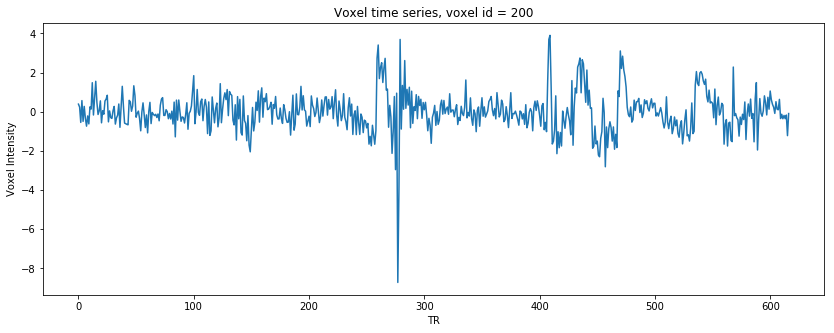

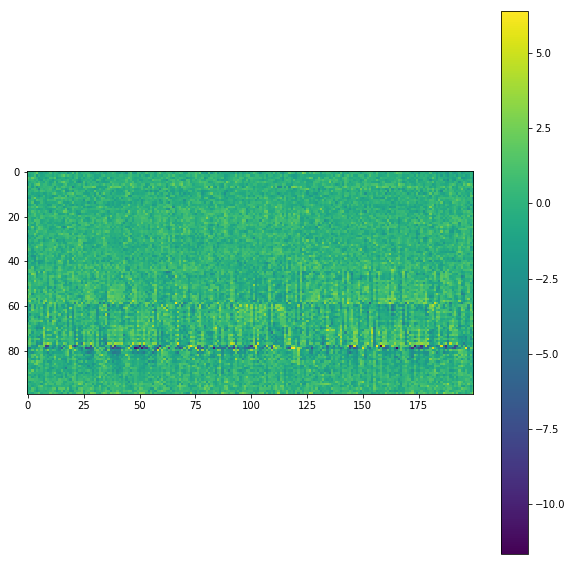

In [20]:
# Plot value of voxel_id through time point 650 (there are only 618 time points)
voxel_id = 200

f, ax = plt.subplots(1,1, figsize=(14,5))
ax.plot(epi_mask_data_all[1:650, voxel_id])

ax.set_title('Voxel time series, voxel id = %d' % voxel_id)
ax.set_xlabel('TR')
ax.set_ylabel('Voxel Intensity')

plt.figure(figsize=(10,10))
plt.imshow(epi_mask_data_all[200:300,voxel_id-100:voxel_id+100])
plt.colorbar()
plt.show()



Text(0,0.5,'Voxel Intensity')

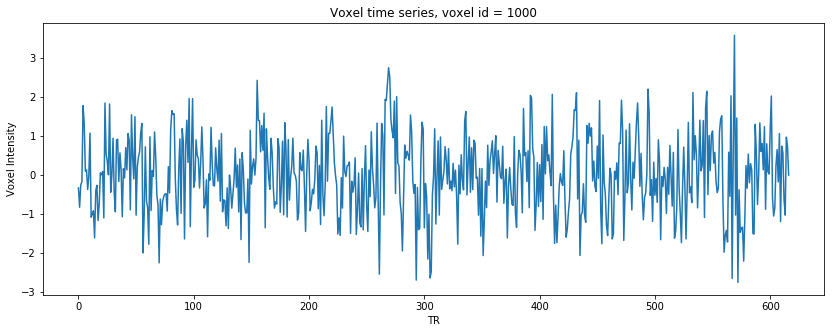

In [15]:
# Plot value of voxel_id through time point 650 (there are only 618 time points)
voxel_id = 1000

f, ax = plt.subplots(1,1, figsize=(14,5))
ax.plot(epi_mask_data_all[1:650, voxel_id])

ax.set_title('Voxel time series, voxel id = %d' % voxel_id)
ax.set_xlabel('TR')
ax.set_ylabel('Voxel Intensity')

In [13]:
x_mean = np.mean(epi_mask_data_all, axis=0)
x_std = np.std(epi_mask_data_all, axis=0, dtype=np.float64)

print('the mean of 1st few time points:\n', x_mean[0:10])
print('')
print('the std of 1st few time points:\n', x_std[0:10])
print('')
print(np.shape(x_mean))
print(np.shape(x_std))
print('')
print(np.amin(x_mean), np.amax(x_mean))
print(np.amin(x_std), np.amax(x_std))

print(x_std)

the mean of 1st few time points:
 [ 2.11984332e-17 -2.48812118e-17  5.03013668e-18  1.41921714e-17
 -2.62285698e-17 -2.20854439e-17 -9.34168241e-18  1.44297134e-17
  2.78453995e-18  7.87081655e-18]

the std of 1st few time points:
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

(476687,)
(476687,)

-2.0415526907902048e-16 1.568324758086993e-16
0.9999999999999981 1.000000000000002
[1. 1. 1. ... 1. 1. 1.]


**Exercise 7:**<a id="ex7"></a> Plot the distribution of values as a histogram. Sample histogram code can be found [here.](https://matplotlib.org/examples/statistics/histogram_demo_histtypes.html)


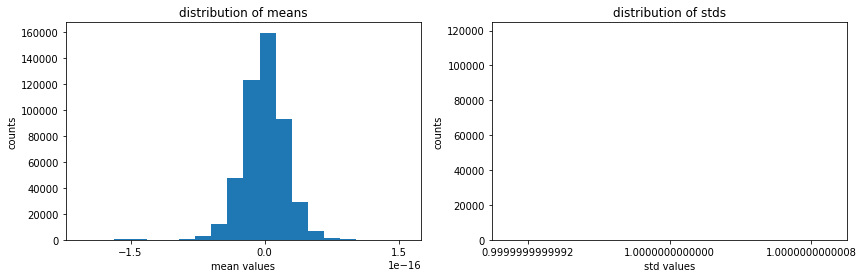

In [14]:
f, axes = plt.subplots(1, 2, figsize = (14,4))

n_bins = 20

axes[0].hist(x_mean, bins = n_bins)
axes[0].set_title('distribution of means')
axes[0].set_xlabel('mean values')
axes[0].set_ylabel('counts')
axes[0].xaxis.set_major_locator(plt.MaxNLocator(3))

axes[1].hist(x_std, bins = n_bins)
axes[1].set_title('distribution of stds')
axes[1].set_xlabel('std values')
axes[1].set_ylabel('counts')
axes[1].xaxis.set_major_locator(plt.MaxNLocator(3))
axes[1].get_xaxis().get_major_formatter().set_useOffset(False)

plt.show()